# Automated Glioma Segmentation using 3D Attention UNet 
Diedre Santos do Carmo

## Abstract
Segmentation of Glioma from three dimensional magnetic resonance imaging (MRI) is necessary for diagnosis and surgical treatment of patients with brain tumor. Manual segmentation is expensive, requiring medical specialists. In the recent years, the Brain Tumor Segmentation Challenge (BraTS) has been calling researchers to submit automated glioma segmentation methods for evaluation and discussion over their public, multimodality MRI dataset, with manual annotations. This paper presents a variation of the famous encoder-decoder architecture, UNet, employing modern deep learning techniques in its architecture and optimization. Resulting Dice in the test set are WT: (TODO), TC: (TODO), EC: (TODO). 

## Executable Paper
This is an executable paper. The code cells can be run to reproduce important steps of this research. Code Cell 0 will setup the enviroment. 

MLflow is used to manage experiment runs, logging to the cell output what command was executed. Details from each run can be visualized by runnning "mlflow ui" on the directory of this notebook and accessing http://localhost:5000 on your browser. 

In [1]:
import mlflow
import os

from src.notebook_utils import view_image

# Intermediate place to save mlflow logs
os.makedirs("logs", exist_ok=True)

## Introduction
Assessment of brain tumors is important in the diagnostic of Cancer <cite data-cite="7898824/32A6LUAJ"></cite>. Automatic segmentation can aid in this assessment, allowing for description of relevant tumor features such as its volume. However, tumors are very heterogeneous in shape, having different associated grades and classifications. Due to this variance, automatic segmentation of brain tumors is still a challenge <cite data-cite="7898824/B7ZKPB79"></cite>.

A source of public glioma type brain tumors is the BraTS challenge <cite data-cite="7898824/YLKCBVFB"></cite>. This challenge expects high quality automatic segmentations of glioma regions, annotated over the provided four modalities of MRI, T1, contrast enhanced T1, T2 and FLAIR (Figure 1). The conception of the challenge came from the high inter-rater disagreement between expert raters in 2012 of up to 0.74 DICE <cite data-cite="7898824/93RWH6ZN"></cite>. Currently, most top-ranking methods in the challenge use Deep Learning <cite data-cite="7898824/T6JZA6G5"></cite> based methods. 

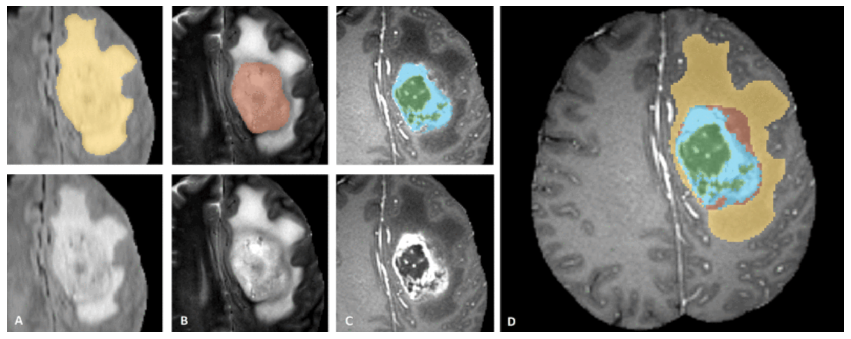

In [2]:
view_image("figures/tumor_brats.png")

Figure 1: A sample manual annotation of a glioma. (a) edema (yellow), (b) non-enhancing solid core (red), (c) necrotic/cystic core (green), enhancing core(blue). (d) Combined segmentations. Reproduced from <cite data-cite="7898824/YLKCBVFB"></cite>.

Adaptation of the famous UNet <cite data-cite="7898824/WEA99PRW"></cite> architecture is a common approach in recent years, with many succesful methods, e. g.: <cite data-cite="7898824/552HYZPE"></cite>, <cite data-cite="7898824/N2ISPHA8"></cite>, <cite data-cite="7898824/97EEBQDV"></cite>, <cite data-cite="7898824/NDZEHRVN"></cite>, <cite data-cite="7898824/TJ8EPCJ6"></cite> and <cite data-cite="7898824/8WQUNYUI"></cite>. 

<cite data-cite="7898824/552HYZPE"></cite> achieved top perfomance using an ensemble of four medical image segmentation CNN architectures, including 2 U-Net based ones, winning BRATS in 2017. The author proposes that its ensemble strategy aims to reduce the impact of different hyperparameters and bias employed to each architecture, by averaging their results.

Isensee Et al. adapted the UNet for 3D convolutions, with more skip connections, less channels, intensive augmentation, and a multi-class adaptation of DICE Loss. Interestingly, this is one of the leading methods from the 2017 <cite data-cite="7898824/N2ISPHA8"></cite> and the 2018 <cite data-cite="7898824/97EEBQDV"></cite> challenge using mostly a single U-Net architecture, showing that a well trained U-Net can be superior to complex ensemble approaches. This work seems to have inspired a lot of the 2019 submissions, which used similar hyperparameters and attempt to use a modified 3D UNet.

The winner of the 2018 challenge also used an U-Net like architecture <cite data-cite="7898824/NDZEHRVN"></cite>. The main novelty of this work consisted of using a second branch in the decoder part of the architecture, reconstructing the original image as a means of regularization of the encoder. Another difference to basic U-Net is the use of a larger encoder, while most works keep the symmetry between encoder and decoder. 

Myronenko in 2019 <cite data-cite="7898824/TJ8EPCJ6"></cite> explored variations in the traditional 3D encoder-decoder architecture, repeatedly used in BraTS. This work uses group normalization instead of batch normalization. A custom loss of 3 terms is used, optimized with Adam and progressive learning rate reduction over 300 epochs. Hyperparameters are in general similar to Isensee's work.  The outputs consists of sigmoid nested tumor subregions. The main novelty is the exploration of the custom loss with dice, focal and Acl loss, which resulted in good relative performance to other submitted methods. 

The winner of the 2019 challenge <cite data-cite="7898824/8WQUNYUI"></cite> used two UNets, one producing a coarse segmentation and other refining that segmentation, using multi stage loss applications. Labels learned are directly the overlapping regions, with a modified Dice Loss where DICE per region is simply added, using similar parameters in optimization to Isensee's work. 

3D UNet like architectures have been achieving top performance in BraTS year after year. This paper proposes to further explore the potential of the UNet encoder-decoder architecture, with the use of attention modules and other modifications recently featured in the literature.

## Data
The BraTS 2020 dataset contains 369 MRI scans of various modalities: T1, post-contrast T1, T2, and FLAIR volumes. All scans are of Low or High grade gliomas (LGG/HGG), acquired with different clinical protocols and various scanners from multiple institutions.

All Subjects have manual segmentations, performed by one to four raters, following the same protocol, with the resulting segmentation being approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET), the peritumoral edema (ED), and the necrotic and non-enhancing tumor core (NET), as described in the latest BraTS summarizing paper <cite data-cite="7898824/B7ZKPB79"></cite>. The provided data are distributed after pre-processing: co-registration to the same anatomical template, interpolation to the same resolution and skull-stripping.

Additional pre-processing applied in this methodology follows <cite data-cite="7898824/N2ISPHA8"></cite>. The images are subtracted by the mean and divided by the standard deviation of the brain region, and clipped inside the interval -5 to 5. Finally, they are min-max normalized to the interval 0 to 1.

This paper will split the challenge's (shuffled) training data in a hold-out approach of 70% training, 10% validation and 20% for the final test set, since the challenge validation and test sets are not available yet for 2020.  

The training data for 2020's challenge will be downloaded by Code Cell 1 and the pre processing can be reproduced by Code Cell 2. Code Cell 3 visualizes slices from the pre-processed data.

### Code Cell 1: Download the original BraTS 2020 data from figshare and unpack

In [31]:
if not os.path.isfile(os.path.join("data", "data.zip")):
    print("Original data not found, downloading it...")
    !wget https://ndownloader.figshare.com/files/22813406?private_link=466e909eea5a3e8ec1e3 -O data/data.zip
else:
    print("Original data already downloaded.")

if os.path.isdir("data/MICCAI_BraTS2020_TrainingData"):
    print("Original data already unpacked.")
else:
    print("Decompressing data...")
    !unzip -q data/data.zip -d data
    print("Done.")

Original data already downloaded.
Original data already unpacked.


### Code Cell 2: Preprocess the data

In [32]:
parameters = {"data_path": "data/MICCAI_BraTS2020_TrainingData"}
print("Performing pre-processing, this might take some minutes.")
run = mlflow.projects.run('.', entry_point="pre_process", use_conda=False, 
                          parameters=parameters,
                          experiment_name="pre_processing")
print("Pre-processing done. Logs saved as mlflow artifact.")

2020/05/27 21:50:09 INFO mlflow.projects: === Created directory /tmp/tmp5cy8quk6 for downloading remote URIs passed to arguments of type 'path' ===
2020/05/27 21:50:09 INFO mlflow.projects: === Running command 'python3 src/brats_preprocess.py --data_path /home/diedre/git/BTRSeg/data/MICCAI_BraTS2020_TrainingData' in run with ID 'fa29ddcf280b48d0856bb0a1e80b5ccc' === 
Performing pre-processing, this might take some minutes.
2020/05/27 21:57:11 INFO mlflow.projects: === Run (ID 'fa29ddcf280b48d0856bb0a1e80b5ccc') succeeded ===
Pre-processing done. Logs saved as mlflow artifact.


### Code Cell 3: Generates and visualizes a display of the pre-processed data

2020/05/27 22:25:43 INFO mlflow.projects: === Created directory /tmp/tmpgyq4z2pg for downloading remote URIs passed to arguments of type 'path' ===
2020/05/27 22:25:43 INFO mlflow.projects: === Running command 'python3 src/visualize_npz.py --input /home/diedre/git/BTRSeg/data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_preprocessed.npz --no_display' in run with ID 'bf7dbd3cb9d5489e86ef1d3254e13337' === 
Generating data visualization...
2020/05/27 22:25:46 INFO mlflow.projects: === Run (ID 'bf7dbd3cb9d5489e86ef1d3254e13337') succeeded ===
Visualization logged as an artifact and saved in figures/display.png


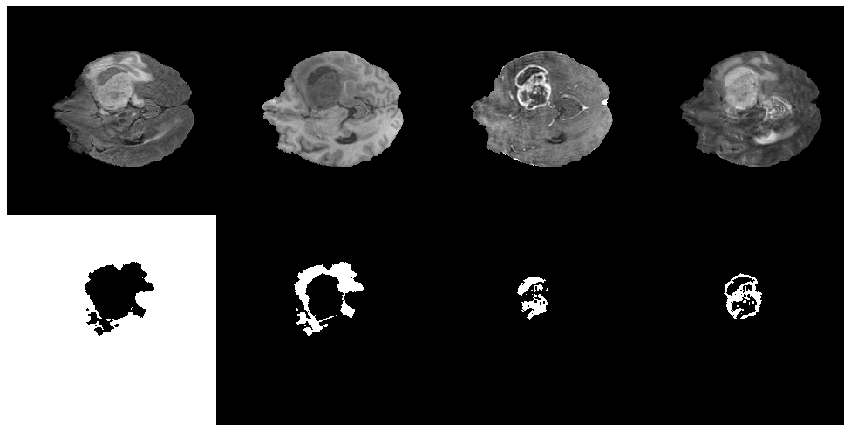

In [33]:
# Change the input to generate and visualize for another .npz file.
parameters = {"input": "data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_preprocessed.npz"}

print("Generating data visualization...")
run = mlflow.projects.run('.', entry_point="visualize", use_conda=False, 
                          parameters=parameters,
                          experiment_name="pre_processing")  
print("Visualization logged as an artifact and saved in figures/display.png")

# This image is generated by the above run. 
view_image("figures/display.png")                           

Figure 1: The four modalities are showcased, in order: FLAIR, T1, T1 with Contrast and T2. Also displayed in the bottom row are the four segmentation targets: background, edema (ED), non-enhancing tumor (NET) and enhancing tumor (ET).

## Methodology
TODO DRAW.IO WORKFLOW FIGURE HERE

This method, named BTRSeg, leverages modified, fully 3D, attention based, UNet like encoder-decoder CNNs. The rest of this text depends on experiments that are being performed right. 

Architecture figure will depend on what is the final best architecture from experiments.

## Experiments and Results
The rest of this text depends on experiments that are being performed right now.

| That | Is | A | Results | Table |
| --- | --- | --- | --- | --- |
| ABC  | 0  | 0.1 |   0.2    |  0.3 |
| CBA  | 0.9  | 0.15 |   0.442    |  -0.3 |


## Discussion
Results show that... I dont know yet. We will see.

## Conclusion
We conclude that... something.

## References
<div class="cite2c-biblio"></div>